## Install CLIP

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4vsavpa4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4vsavpa4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 582.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

## Training and save model(run once before you have a model)

In [ ]:
import clip
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),  # CLIP normalization
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load CLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)

def extract_features(data_loader):
    all_features = []
    all_labels = []

    for images, labels in data_loader:
        images = images.to(device)
        with torch.no_grad():
            features = clip_model.encode_image(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features from train and test datasets
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Train a linear classifier on the extracted features
classifier = LogisticRegression(max_iter=1000, verbose=1, n_jobs=-1)
classifier.fit(train_features, train_labels)

# Predict and evaluate on the test set
test_preds = classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Test accuracy: {test_accuracy}')
# Save the model to a file
joblib_file = "cifar100_clip_vit14_classifier.pkl"
joblib.dump(classifier, joblib_file)

100%|██████████| 169001437/169001437 [00:13<00:00, 12627795.21it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


100%|███████████████████████████████████████| 890M/890M [00:20<00:00, 46.3MiB/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Test accuracy: 0.8478


['cifar100_clip_vit14_classifier.pkl']

## Load model and evaluation

In [2]:
import clip
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),  # CLIP normalization
])

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load CLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)

def extract_features(data_loader):
    all_features = []
    all_labels = []

    for images, labels in data_loader:
        images = images.to(device)
        with torch.no_grad():
            features = clip_model.encode_image(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features from test datasets
test_features, test_labels = extract_features(test_loader)
# Load the saved model
loaded_classifier = joblib.load("cifar100_clip_vit14_classifier.pkl")

# Predict and evaluate on the test set
test_preds = loaded_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)
#Accuracy using Vit/L-14: 0.8478
print(f'Test accuracy (loaded model): {test_accuracy}')


100%|██████████| 169001437/169001437 [00:12<00:00, 13191785.71it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


100%|███████████████████████████████████████| 890M/890M [00:14<00:00, 62.9MiB/s]


Test accuracy (loaded model): 0.8478


## Do some visualizations (sample prediction)

Using random 20 samples to evaluate its performance

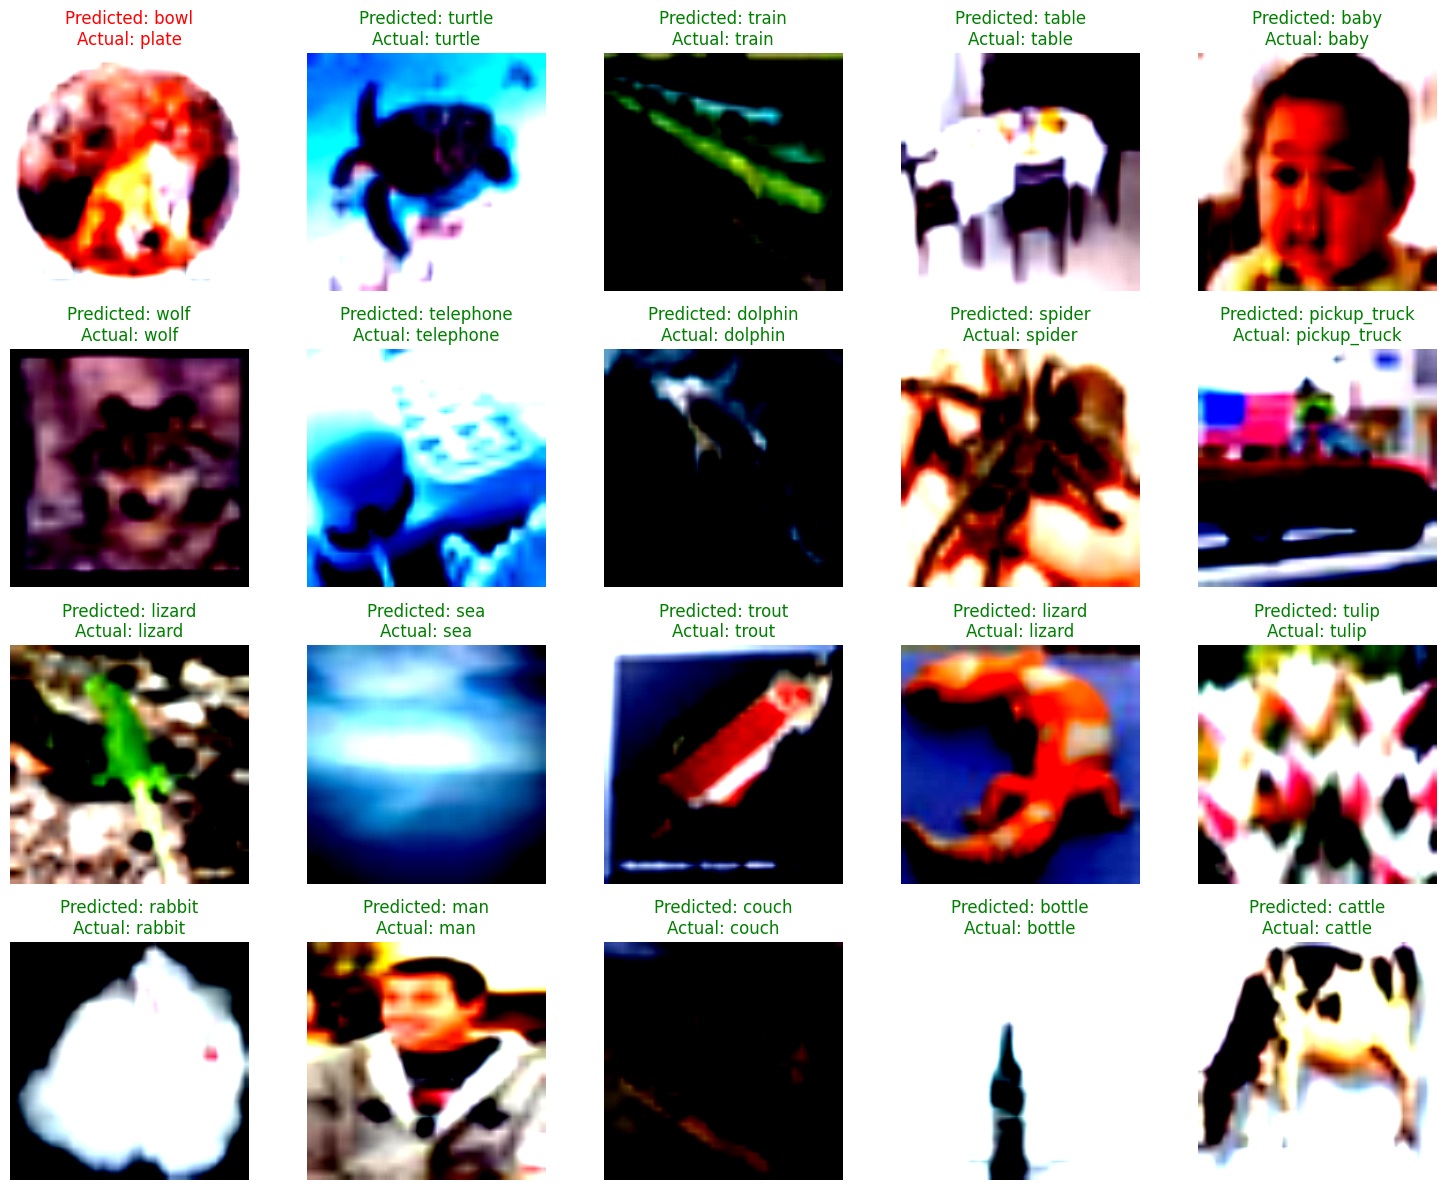

In [15]:
import random
import matplotlib.pyplot as plt

# Select random samples from the test set
num_samples = 20
random_indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    image, true_label = test_dataset[idx]
    image = image.permute(1, 2, 0).numpy()  # Convert to numpy and permute dimensions

    # Predict using the loaded classifier
    features = test_features[idx].reshape(1, -1)  # Reshape to 2D array
    predicted_label = loaded_classifier.predict(features)[0]

    # Determine label color based on prediction correctness
    if predicted_label == true_label:
        label_color = 'green'
    else:
        label_color = 'red'

    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Predicted: {test_dataset.classes[predicted_label]}\nActual: {test_dataset.classes[true_label]}', color=label_color)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
